Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


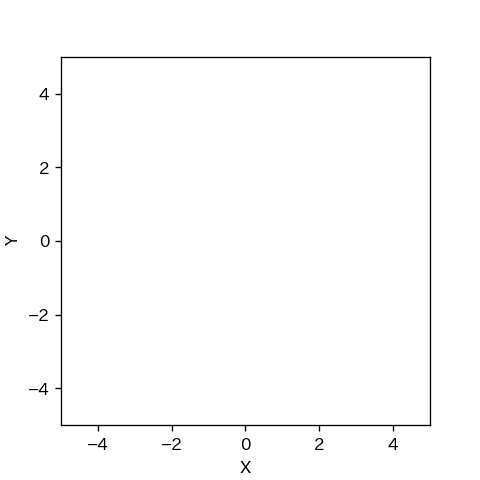

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import*

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): 
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
                
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.sensor_resetting(observation) 
        else:
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_phantom_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m,phantom_prob=0.1),agent=a,color="red")
    world.append(r)
    
    world.draw()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


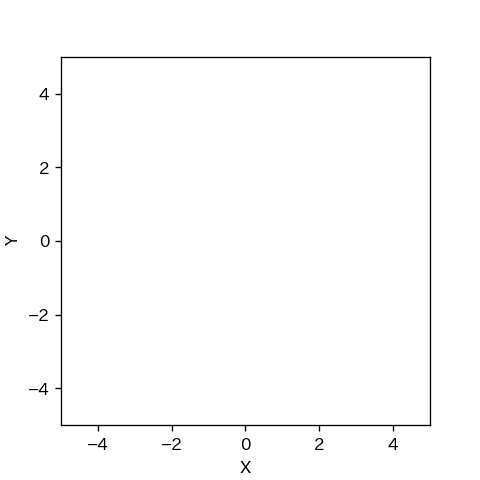

(array([-3.52636359,  0.32972513, -2.73899556]),
 array([-2.89003095,  3.92469355,  2.83834364]))

In [4]:
trial_phantom_kidnap(True)

In [5]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_phantom_kidnap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

[0.6842317940330814]
[1.695905472293395]
[1.9357089951117947]
[4.6826511116135014]
[5.863540648136851, 3.7912467421137634]
[3.7367652047110127]
[1.8476467228259197]
[4.259164332370548]
[3.682163544028723, 4.258082683298729]
[3.0430292570672397]
[3.59037915480602]
[3.779750919242794]
[3.9031395044782964]
[3.0842114831177514]
[3.640004286453678]
[5.674120327291871]
[3.5777648262466006]
[5.951519075627501]
[6.137192199955113, 1.4061314253635346]
[4.830335035320128, 2.840970111333368]
[5.286579581061847]
[3.8980906535867845]
[3.371046216292018]
0 真値: [-1.65506785 -1.99145042  3.003573  ] 推定値: [0.04309406 1.8746465  4.02847464] 誤差: 4.222612843774999
[3.683189674296685]
[4.459431695521222]
[4.855539089720848]
[4.473089357258387]
[3.732890965131547, 1.7733561722748106]
[4.704212587669991]
[5.9114366747207745]
[2.7939852201013107]
[2.6846546225407235, 5.197569520054249]
[3.458703251196371]
[2.503698312880888]
[2.5459796329315076, 2.6359477727563845]
[2.0233192205623527]
[5.882401639060095, 3.0

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[1.233200692884437]
[2.865424076333021]
[5.073407687107839]
[1.583655903530311, 4.570400118082857]
[2.9304381787316736, 5.6965966664843695]
[2.72413913210456, 3.75017309212905]
[3.434812948687239, 3.786309035730576]
[5.156903388423945]
[3.763692225932208]
[3.1007661910127884, 4.593494375626898]
[2.109660652160323]
[5.111543323510727]
[4.592605313495937]
[2.1889460615022016]
[4.048617242708532]
[4.475676583934526]
[2.4863827219828964]
[1.9956000139720085]
[5.631600691250822, 4.213329447568692]
[1.936794352705286]
[5.117897057052079]
[1.8620336521484608]
[1.790226800628022]
[2.072326094416205]
[1.0695076933004755, 1.5911759469510538]
[1.6254918711463748]
[1.6279481478038398]
[1.4481916233915464]
[2.918183071965948, 1.2229124112474894]
20 真値: [ 1.58715691 -1.90473613  4.8071962 ] 推定値: [ 2.45845765 -1.9222436  -2.20908691] 誤差: 0.8714766206814577
4
[6.625552939593955]
[3.869346080285269]
[3.579830858344313]
[4.731002398937936]
[3.496423623071485]
[2.57801875323291]
[2.8104610686053206, 6.27